# Dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import NotFittedError
from sklearn.metrics import r2_score, mean_absolute_error

sns.set_theme()

# Loading the Raw Data

In [6]:
df = pd.read_csv('gpa_dataset.csv')

In [7]:
df.head()

,SAT,"Rand 1,2,3",GPA
0,1714,1,2.40
1,1664,3,2.52
2,1760,3,2.54
3,1685,3,2.74
4,1693,2,2.83


# Data Preprocess

In [12]:
df.describe(include="all").round()

,SAT,"Rand 1,2,3",GPA
count,84.0,84.0,84.0
mean,1845.0,2.0,3.0
std,105.0,1.0,0.0
min,1634.0,1.0,2.0
25%,1772.0,1.0,3.0
50%,1846.0,2.0,3.0
75%,1934.0,3.0,4.0
max,2050.0,3.0,4.0


# Modeling

In [ ]:
# Splitting features from target
x = df.drop(['GPA'], axis=1)
y = df['GPA']

In [ ]:
# Features
x.head()

,SAT,"Rand 1,2,3"
0,1714,1
1,1664,3
2,1760,3
3,1685,3
4,1693,2


In [ ]:
# Target
y.head()

0    2.40
1    2.52
2    2.54
3    2.74
4    2.83
Name: GPA, dtype: float64

In [ ]:
# Split the data, 80-20
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=123)

print(f"""
X Train Shape: {x_train.shape}
X Test Shape: {x_test.shape}
Y Train Shape: {y_train.shape}
Y Test Shape: {y_test.shape}"""
)


X Train Shape: (67, 2)
X Test Shape: (17, 2)
Y Train Shape: (67,)
Y Test Shape: (17,)


In [ ]:
# Create a pipeline per model
pipelines = {
    'ols':make_pipeline(LinearRegression()),
    'rf':make_pipeline(RandomForestRegressor(random_state=1234)),
    'gb':make_pipeline(GradientBoostingRegressor(random_state=1234)),
    'ridge':make_pipeline(Ridge(random_state=1234)),
    'lasso':make_pipeline(Lasso(random_state=1234)),
    'enet':make_pipeline(ElasticNet(random_state=1234)),
}

In [ ]:
# Print all the, algorithm, pipelines available and their parameters
for algorithm, pipeline in pipelines.items():
    print(f"""
    Algorithm: {algorithm}
    Pipeline: {pipeline})
    Parameters: {v.get_params()}
    """)


    Model: ols
    Pipeline: Pipeline(steps=[('linearregression', LinearRegression())]))
    Params: {'memory': None, 'steps': [('linearregression', LinearRegression())], 'transform_input': None, 'verbose': False, 'linearregression': LinearRegression(), 'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__n_jobs': None, 'linearregression__positive': False}
    

    Model: rf
    Pipeline: Pipeline(steps=[('randomforestregressor',
                 RandomForestRegressor(random_state=1234))]))
    Params: {'memory': None, 'steps': [('randomforestregressor', RandomForestRegressor(random_state=1234))], 'transform_input': None, 'verbose': False, 'randomforestregressor': RandomForestRegressor(random_state=1234), 'randomforestregressor__bootstrap': True, 'randomforestregressor__ccp_alpha': 0.0, 'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 1.0, 'randomforestregress

In [ ]:
# Parameters to test
hypergrid = {
    'ols': {
        
    },
    'rf': {
        'randomforestregressor__min_samples_split':[2,4,6],
        'randomforestregressor__min_samples_leaf':[1,2,3]
    },
    'gb':{
        'gradientboostingregressor__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'ridge':{
        'ridge__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'lasso':{
        'lasso__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'enet':{
        'elasticnet__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    }
}

In [64]:
# Empty dictionary to store models
fit_models = {}

# Train models over a parameter grid
for algorithm, pipeline in pipelines.items():
    # Optimize by cross-validated grid-search over a parameter grid
    model = GridSearchCV(pipeline, hypergrid[algorithm], cv=10, n_jobs=-1)
    try:
        print(f"Starting training for *** {algorithm} ***")
        model.fit(x_train, y_train)
        fit_models[algorithm] = model
        print(f"{algorithm} has been successfully fit")
    except NotFittedError as e:
        print(repr(e))

Starting training for *** ols ***
ols has been successfully fit
Starting training for *** rf ***
rf has been successfully fit
Starting training for *** gb ***
gb has been successfully fit
Starting training for *** ridge ***
ridge has been successfully fit
Starting training for *** lasso ***
lasso has been successfully fit
Starting training for *** enet ***
enet has been successfully fit


In [65]:
fit_models['ridge'].predict(x_test)

array([3.46565932, 3.06012079, 3.05840935, 3.47090242, 3.39575139,
       3.21916134, 3.60190728, 3.50236099, 3.49180228, 3.30836647,
       3.23143149, 3.46387537, 3.32060036, 3.35373411, 3.12307419,
       3.30133942, 3.56171022])

# Evaluation

In [66]:
df_model_evaluation = pd.DataFrame(columns=['Algo', 'R2 Score', 'Mean Absolute Error'])
index = 0

for algo,model in fit_models.items():
    yhat = model.predict(x_test)
    print('{} scores - R2:{} MAE:{}'.format(algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)))
    
    index += 1
    df_model_evaluation.loc[index] = [algo, r2_score(y_test, yhat), mean_absolute_error(y_test, yhat)]

ols scores - R2:0.09364110349969523 MAE:0.2105938904380252
rf scores - R2:0.0461507309337682 MAE:0.21251312795048066
gb scores - R2:0.03968361711467605 MAE:0.20961526136195452
ridge scores - R2:0.09374606143119202 MAE:0.21059843065140413
lasso scores - R2:0.1105533689249415 MAE:0.20997577989214344
enet scores - R2:0.10411696898210498 MAE:0.21039795286061125


In [98]:
df_model_evaluation = df_model_evaluation.sort_values(by='R2 Score', ascending=False).reset_index(drop= True)
df_model_evaluation

,Algo,R2 Score,Mean Absolute Error
0,ridge,0.324965,0.202332
1,ols,0.324952,0.202332
2,enet,0.324122,0.202590
3,lasso,0.322918,0.202856
4,gb,0.305686,0.205583
5,rf,0.254759,0.215273


In [99]:
df_model_evaluation.index

RangeIndex(start=0, stop=6, step=1)

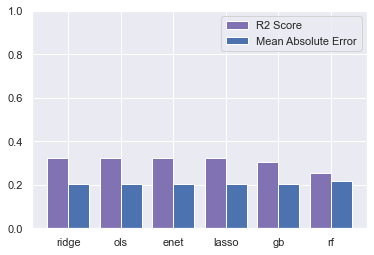

In [100]:
plt.clf()
barwidth = 0.4
x_plot_1 = df_model_evaluation.index
x_plot_2 = x_plot_1+barwidth
y_plot_1 = df_model_evaluation['R2 Score']
y_plot_2 = df_model_evaluation['Mean Absolute Error']
x_ticks = df_model_evaluation['Algo']

plt.bar(x_plot_1, y_plot_1, width=barwidth, color='C254', label= 'R2 Score')
plt.bar(x_plot_2, y_plot_2, width=barwidth, color='C250', label= 'Mean Absolute Error')
plt.xticks(x_plot_1+barwidth/2, x_ticks)
plt.ylim(0,1) 
plt.legend()
plt.show()

In [101]:
best_model = df_model_evaluation.iloc[0,0]
best_model

'ridge'